## Forecasting - Facebook Prophet
https://facebook.github.io/prophet/

Prophet model: very good for date-depending analyze, there are variables for Monday to Saterday, and holiday.

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from fbprophet import Prophet 



%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)



In [3]:
%matplotlib inline
plt.style.use('fivethirtyeight')

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Rolling Mean

In [5]:
df = pd.DataFrame({'X': np.arange(0,10)}) # generate an input df
df['y']=df.rolling(3).mean() # take the window and write the average as the result
df

,X,y
0,0,NaN
1,1,NaN
2,2,1.0
3,3,2.0
4,4,3.0
5,5,4.0
6,6,5.0
7,7,6.0
8,8,7.0
9,9,8.0


## small data set

In [22]:
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')
df=df_all[['date','Germany']]
df=df.rename(columns={'date': 'ds',
                        'Germany': 'y'})


,ds,y
108,2020-05-09,171324
109,2020-05-10,171879
110,2020-05-11,172576
111,2020-05-12,173171
112,2020-05-13,174098


In [25]:
df.head()

,ds,y
0,2020-01-22,0
1,2020-01-23,0
2,2020-01-24,0
3,2020-01-25,0
4,2020-01-26,0


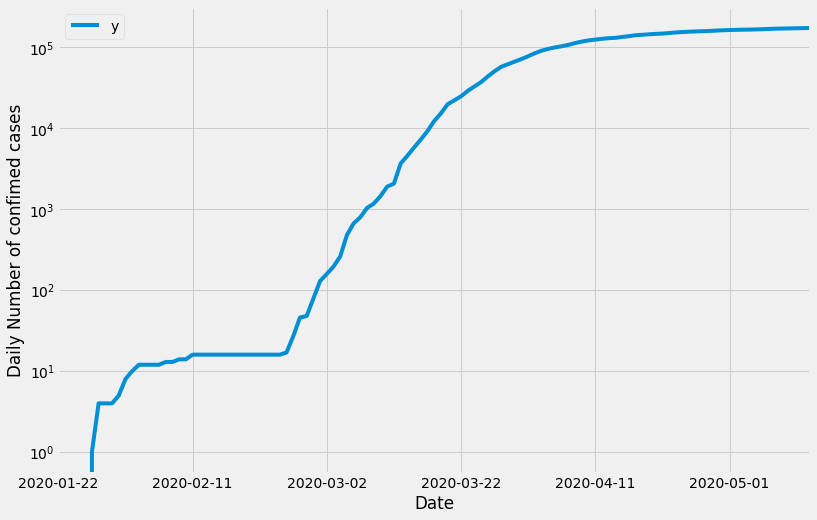

In [7]:
ax = df.set_index('ds').plot(figsize=(12, 8),
                             logy=True)
ax.set_ylabel('Daily Number of confimed cases')
ax.set_xlabel('Date')

plt.show()

In [32]:
# set the uncertainty interval to 95% (the Prophet default is 80%)

# my_model = Prophet(interval_width=0.95) # piecwise linear model
my_model = Prophet(growth='logistic')   # logistic model

In [33]:
df['cap']=1000000. #for logistic model

my_model.fit(df)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
# define the periods and the frequency 'D'== days

future_dates = my_model.make_future_dataframe(periods=7, freq='D')# predict 7 days
future_dates['cap']=1000000. # only mandatory for the logistic model
future_dates.tail()

,ds,cap
115,2020-05-16,1000000.0
116,2020-05-17,1000000.0
117,2020-05-18,1000000.0
118,2020-05-19,1000000.0
119,2020-05-20,1000000.0


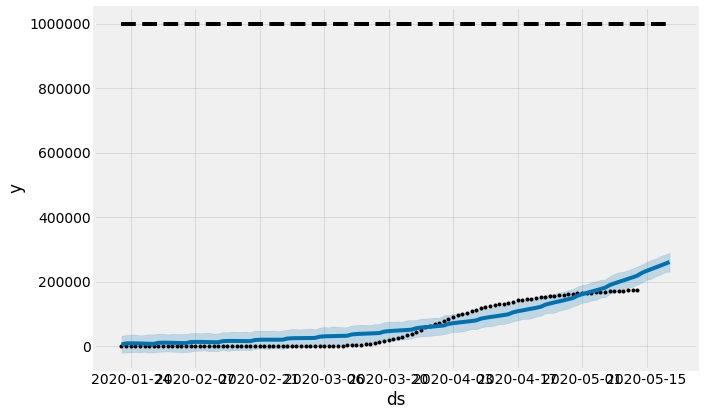

In [35]:
# predict according to the scikit-learn standard

forecast = my_model.predict(future_dates)
my_model.plot(forecast,
              uncertainty=True ); # since fbprohet is rendering the output

In [36]:
import plotly.offline as py
from fbprophet.plot import plot_plotly

fig = plot_plotly(my_model, forecast)  # This returns a plotly Figure

fig.update_layout(
    width=1024,
    height=900,
    xaxis_title="Time",
    yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
)
fig.update_yaxes(type="log",range=[1.1,5.5])
py.iplot(fig)

In [37]:
forecast.sort_values(by='ds').head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,6822.247695,1000000.0,-21037.176372,31694.840795,6822.247695,6822.247695,-1751.526074,-1751.526074,-1751.526074,-1751.526074,-1751.526074,-1751.526074,0.0,0.0,0.0,5070.721621
1,2020-01-23,7050.776114,1000000.0,-20108.313409,34246.873919,7050.776114,7050.776114,1112.287466,1112.287466,1112.287466,1112.287466,1112.287466,1112.287466,0.0,0.0,0.0,8163.063580
2,2020-01-24,7286.903505,1000000.0,-19154.251691,35144.019923,7286.903505,7286.903505,1270.352798,1270.352798,1270.352798,1270.352798,1270.352798,1270.352798,0.0,0.0,0.0,8557.256302
3,2020-01-25,7530.878722,1000000.0,-18449.621913,35979.558482,7530.878722,7530.878722,857.472209,857.472209,857.472209,857.472209,857.472209,857.472209,0.0,0.0,0.0,8388.350931
4,2020-01-26,7782.958511,1000000.0,-19648.107142,32988.340108,7782.958511,7782.958511,201.249635,201.249635,201.249635,201.249635,201.249635,201.249635,0.0,0.0,0.0,7984.208147


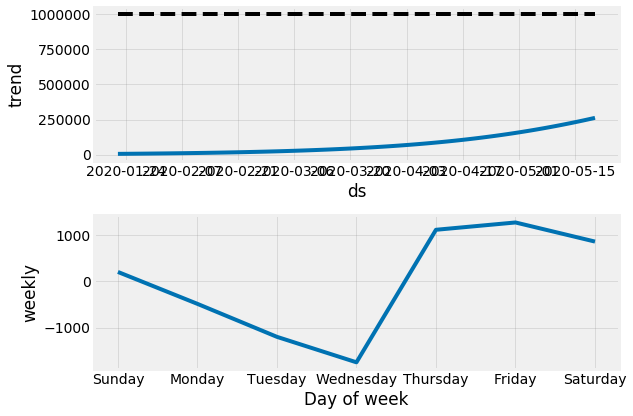

In [38]:
my_model.plot_components(forecast);

TypeError: float() argument must be a string or a number, not 'Period'

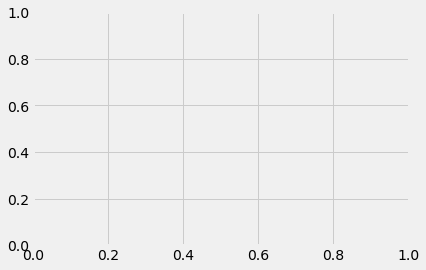

In [39]:
#do not works
foplot = forecast[['ds','trend']].set_index('ds')
foplot.plot()

## Cross validation

In [40]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(my_model, 
                         initial='40 days', # we take the first 40 days for initial training, 02-22~03-02
                         period='1 days',  # every  days a new prediction run
                         horizon = '7 days') #we predict 7days into the future

INFO:fbprophet:Making 66 forecasts with cutoffs between 2020-03-02 00:00:00 and 2020-05-06 00:00:00


In [41]:
df_cv.sort_values(by=['cutoff','ds'])[0:12]
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-03-03,-1.664082,-45.224957,44.427755,196,2020-03-02
1,2020-03-04,-2.355997,-45.773442,39.520928,262,2020-03-02
2,2020-03-05,1.045051,-43.437925,48.286525,482,2020-03-02
3,2020-03-06,1.939529,-40.448044,43.611107,670,2020-03-02
4,2020-03-07,7.827316,-34.934040,50.714910,799,2020-03-02


In [42]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

# horizon less, prediction better

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,7.912310e+08,28128.827786,20908.714051,0.217508,0.207757,0.015152
1,2 days,1.126540e+09,33563.966508,25916.186459,0.272545,0.291220,0.015152
2,3 days,1.571634e+09,39643.843001,31597.153620,0.333086,0.356222,0.015152
3,4 days,2.157209e+09,46445.766401,38019.299204,0.398992,0.413353,0.000000
4,5 days,2.923325e+09,54067.779107,45287.159726,0.467959,0.470802,0.000000
5,6 days,3.922573e+09,62630.447450,53505.575505,0.546389,0.543107,0.000000
6,7 days,5.223838e+09,72276.122548,62783.818014,0.630527,0.638038,0.000000


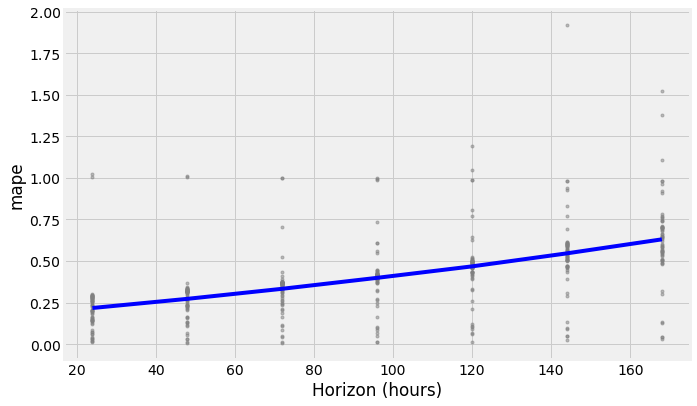

In [43]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape',)

## Diagonalplot 
make sure if the model is good enough

In [44]:
horizon='7 days'
df_cv['horizon']=df_cv.ds-df_cv.cutoff

#filter out 7 days' data
date_vec=df_cv[df_cv['horizon']==horizon]['ds']
y_hat=df_cv[df_cv['horizon']==horizon]['yhat']
y=df_cv[df_cv['horizon']==horizon]['y']
df_cv_7=df_cv[df_cv['horizon']==horizon]


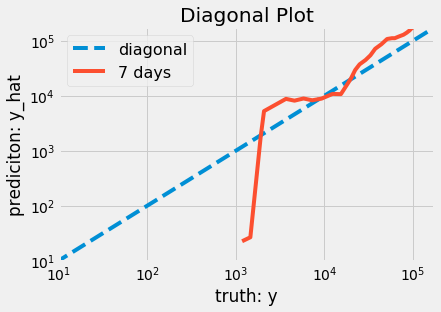

In [45]:

fig, ax = plt.subplots(1, 1)


ax.plot(np.arange(max(y)),np.arange(max(y)),'--',label='diagonal')
ax.plot(y,y_hat,'-',label=horizon)  # horizon is a np.timedelta objct

ax.set_title('Diagonal Plot')
ax.set_ylim(10, max(y))

ax.set_xlabel('truth: y')
ax.set_ylabel('prediciton: y_hat')
ax.set_yscale('log')

ax.set_xlim(10, max(y))
ax.set_xscale('log')
ax.legend(loc='best',
           prop={'size': 16});